In [1]:
!pip install -q -U "tensorflow-text==2.8.*"

     |████████████████████████████████| 4.9 MB 4.7 MB/s 


In [2]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

In [3]:
import pandas as pd

df = pd.read_csv('/content/spam.csv')
df.head()

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [4]:
df['Category'].value_counts()

ham     4825
spam     747
Name: Category, dtype: int64

In [5]:
df_spam = df[df['Category']=='spam']
df_spam.shape

(747, 2)

In [6]:
df_ham = df[df['Category']=='ham']
df_ham.shape

(4825, 2)

In [7]:
df_ham_downsampled = df_ham.sample(df_spam.shape[0])
df_ham_downsampled.shape

(747, 2)

In [8]:
df_balanced = pd.concat([df_spam,df_ham_downsampled])
df_balanced.shape

(1494, 2)

In [9]:
df_balanced['Category'].value_counts()

spam    747
ham     747
Name: Category, dtype: int64

In [10]:
df_balanced['spam']=df_balanced['Category'].apply(lambda x: 1 if x=='spam' else 0)
df_balanced.head()


,Category,Message,spam
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
5,spam,FreeMsg Hey there darling it's been 3 week's n...,1
8,spam,WINNER!! As a valued network customer you have...,1
9,spam,Had your mobile 11 months or more? U R entitle...,1
11,spam,"SIX chances to win CASH! From 100 to 20,000 po...",1


In [11]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(df_balanced['Message'],df_balanced['spam'],stratify=df_balanced['spam'])

In [12]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

In [16]:
# Bert layers
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)

# Neural network layers
l = tf.keras.layers.Dropout(0.1, name="dropout")(outputs['pooled_output'])
l = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(l)

# Use inputs and outputs to construct a final model
model = tf.keras.Model(inputs=[text_input], outputs = [l])

In [17]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')
]

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=METRICS)

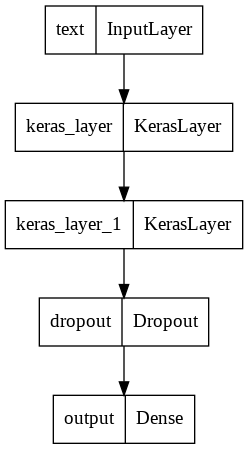

In [26]:
tf.keras.utils.plot_model(model)

In [18]:
model.fit(X_train, y_train, epochs=10)

Epoch 1/10
35/35 [==============================] - 21s 314ms/step - loss: 0.6646 - accuracy: 0.5938 - precision: 0.6044 - recall: 0.5429
Epoch 2/10
35/35 [==============================] - 11s 315ms/step - loss: 0.5242 - accuracy: 0.8000 - precision: 0.7718 - recall: 0.8518
Epoch 3/10
35/35 [==============================] - 11s 318ms/step - loss: 0.4458 - accuracy: 0.8562 - precision: 0.8422 - recall: 0.8768
Epoch 4/10
35/35 [==============================] - 11s 321ms/step - loss: 0.4065 - accuracy: 0.8652 - precision: 0.8520 - recall: 0.8839
Epoch 5/10
35/35 [==============================] - 12s 330ms/step - loss: 0.3689 - accuracy: 0.8866 - precision: 0.8739 - recall: 0.9036
Epoch 6/10
35/35 [==============================] - 11s 326ms/step - loss: 0.3463 - accuracy: 0.8911 - precision: 0.8789 - recall: 0.9071
Epoch 7/10
35/35 [==============================] - 12s 332ms/step - loss: 0.3320 - accuracy: 0.8830 - precision: 0.8692 - recall: 0.9018
Epoch 8/10
35/35 [================

In [19]:
model.evaluate(X_test, y_test)

12/12 [==============================] - 5s 331ms/step - loss: 0.2533 - accuracy: 0.9332 - precision: 0.9500 - recall: 0.9144


[0.2533336281776428, 0.9331550598144531, 0.949999988079071, 0.9144384860992432]

In [20]:
y_predicted = model.predict(X_test)
y_predicted = y_predicted.flatten()

In [21]:
import numpy as np

y_predicted = np.where(y_predicted > 0.5, 1, 0)
y_predicted

array([1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0,
       0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0,
       1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0,
       0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1,
       0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1,
       0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1,
       0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0,
       0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0,
       1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0,

In [22]:
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_test, y_predicted)
cm 

array([[178,   9],
       [ 16, 171]])

Text(33.0, 0.5, 'Truth')

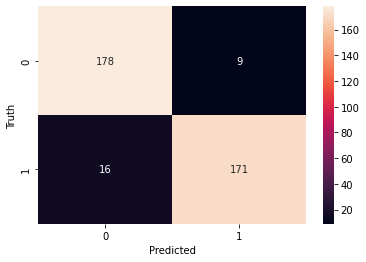

In [23]:
from matplotlib import pyplot as plt
import seaborn as sn
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')


In [24]:
print(classification_report(y_test, y_predicted))

              precision    recall  f1-score   support

           0       0.92      0.95      0.93       187
           1       0.95      0.91      0.93       187

    accuracy                           0.93       374
   macro avg       0.93      0.93      0.93       374
weighted avg       0.93      0.93      0.93       374



In [25]:
reviews = [
    'Enter a chance to win $5000, hurry up, offer valid until march 31, 2021',
    'You are awarded a SiPix Digital Camera! call 09061221061 from landline. Delivery within 28days. T Cs Box177. M221BP. 2yr warranty. 150ppm. 16 . p pÂ£3.99',
    'it to 80488. Your 500 free text messages are valid until 31 December 2005.',
    'Hey Sam, Are you coming for a cricket game tomorrow',
    "Why don't you wait 'til at least wednesday to see if you get your ."
]
model.predict(reviews)

array([[0.7197038 ],
       [0.8312017 ],
       [0.7679221 ],
       [0.15713735],
       [0.09507332]], dtype=float32)